In [2]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC  
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    roc_curve, auc,f1_score
)
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import chromadb

In [3]:

client = chromadb.PersistentClient(path="/opt/airflow/data/chroma_db")

train_collection = client.get_or_create_collection("avis_train")
test_collection  = client.get_or_create_collection("avis_test")

train_results = train_collection.get(
    include=["metadatas", "embeddings", "documents"]
)

x_train = np.array(train_results["embeddings"])
y_train = [m["label"] for m in train_results["metadatas"]]
train_texts = train_results["documents"]

test_results = test_collection.get(
    include=["metadatas", "embeddings", "documents"]
)

x_test = np.array(test_results["embeddings"])
y_test = [m["label"] for m in test_results["metadatas"]]
test_texts = test_results["documents"]



Fitting 5 folds for each of 8 candidates, totalling 40 fits


Meilleurs hyperparamètres : {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
Meilleur score CV (F1-macro) : 0.7386881434655332
 Logistic Regression (après GridSearch) 
Accuracy train: 0.8019
Accuracy test : 0.7773
Gap (overfitting): 0.0246
 Logistic Regression (après GridSearch) 
Accuracy train: 0.7638
Accuracy test : 0.7315
Gap (overfitting): 0.0323


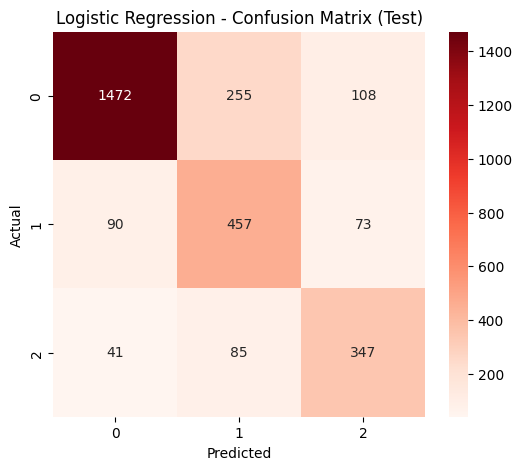

,precision,recall,f1-score,support
negative,0.918278,0.802180,0.856312,1835.000000
neutral,0.573400,0.737097,0.645025,620.000000
positive,0.657197,0.733615,0.693307,473.000000
accuracy,0.777322,0.777322,0.777322,0.777322
macro avg,0.716292,0.757631,0.731548,2928.000000
weighted avg,0.803075,0.777322,0.785240,2928.000000


In [7]:

classes = sorted(list(set(y_train)))
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin  = label_binarize(y_test, classes=classes)

param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "solver": ["lbfgs", "saga"],
    "penalty": ["l2"],
    "max_iter": [1000]
}

log_reg = LogisticRegression(
    solver="saga",
    C=0.1,
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

grid = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring="f1_macro",   
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(x_train, y_train)

best_model = grid.best_estimator_

print("Meilleurs hyperparamètres :", grid.best_params_)
print("Meilleur score CV (F1-macro) :", grid.best_score_)

y_pred_train = best_model.predict(x_train)
y_pred_test  = best_model.predict(x_test)


acc_train = accuracy_score(y_train, y_pred_train)
acc_test  = accuracy_score(y_test, y_pred_test)
f1_train = f1_score(y_train, y_pred_train,average="macro")
f1_test  = f1_score(y_test, y_pred_test,average="macro")

print("="*50)
print(" Logistic Regression (après GridSearch) ")
print("="*50)
print(f"Accuracy train: {acc_train:.4f}")
print(f"Accuracy test : {acc_test:.4f}")
print(f"Gap (overfitting): {acc_train - acc_test:.4f}")
print("="*50)

print("="*50)
print(" Logistic Regression (après GridSearch) ")
print("="*50)
print(f"Accuracy train: {f1_train:.4f}")
print(f"Accuracy test : {f1_test:.4f}")
print(f"Gap (overfitting): {f1_train - f1_test:.4f}")
print("="*50)

cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,5))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Reds")
plt.title("Logistic Regression - Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

report = classification_report(y_test, y_pred_test, output_dict=True)
report_df = pd.DataFrame(report).transpose()
display(report_df)


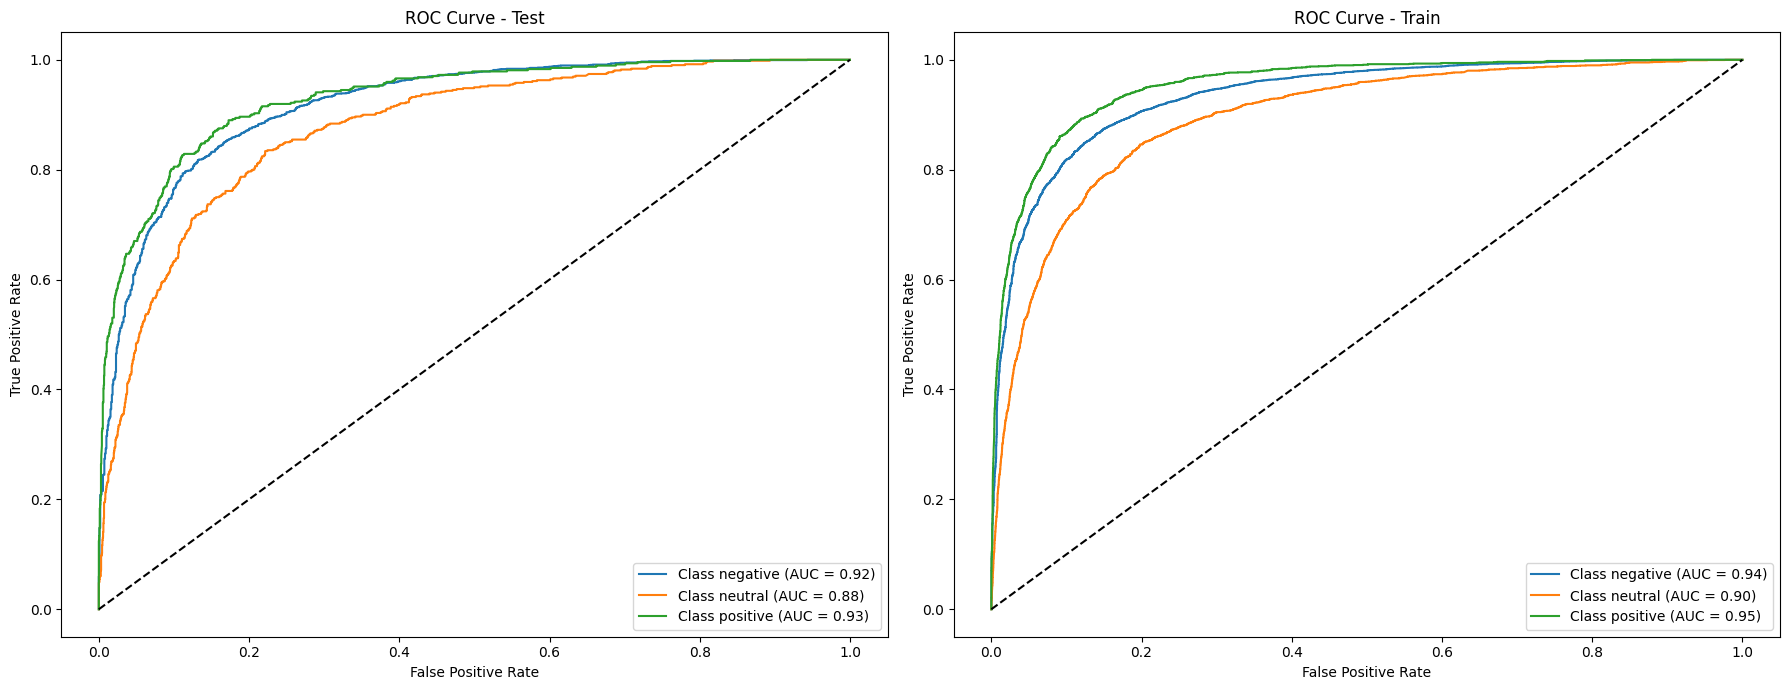

In [5]:

y_score_test  = best_model.predict_proba(x_test)
y_score_train = best_model.predict_proba(x_train)

plt.figure(figsize=(18,7))

plt.subplot(1,2,1)
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_test[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {cls} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve - Test")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.subplot(1,2,2)
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_score_train[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {cls} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve - Train")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.tight_layout()
plt.show()
